<a href="https://colab.research.google.com/github/thinh12112001/Ryerson_MRP/blob/master/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install tensorflow-addons==0.19.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (176, 208)

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory('/content/gdrive/MyDrive/colab/data_04/train',
                                                            shuffle=True,
                                                            label_mode='categorical',
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 5120 files belonging to 2 classes.


In [6]:
validation_dataset = tf.keras.utils.image_dataset_from_directory('/content/gdrive/MyDrive/colab/data_04/validation',
                                                                 shuffle=True,
                                                                 label_mode='categorical',
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1280 files belonging to 2 classes.


In [7]:
test_dataset = tf.keras.utils.image_dataset_from_directory('/content/gdrive/MyDrive/colab/test',
                                                                 shuffle=True,
                                                                 label_mode='categorical',
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1279 files belonging to 2 classes.


In [8]:
WORK_DIR = r'/content/gdrive/MyDrive/colab/test'

CLASSES = [ 'NonAlzheimer',
            'Alzheimer']

IMG_SIZE = 224
IMAGE_SIZE = [176, 208]
DIM = (176, 208)

In [9]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=1280, shuffle=False)

Found 1279 images belonging to 2 classes.


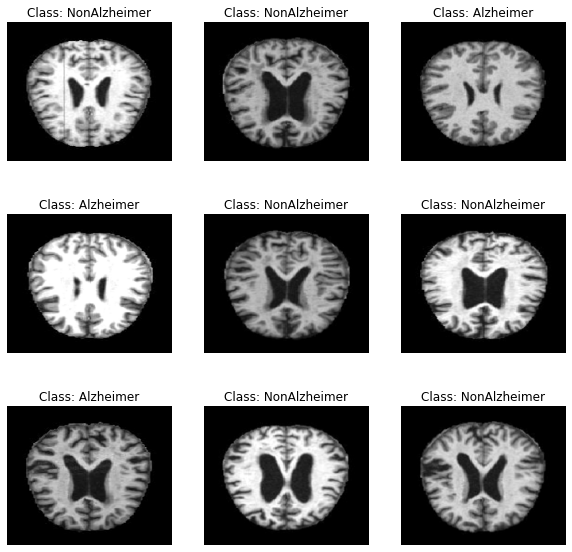

In [10]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 1279)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class: {}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [11]:
train_data, train_labels = train_data_gen.next()
print(train_data.shape, train_labels.shape)

(1279, 176, 208, 3) (1279, 2)


In [12]:
# sm = SMOTE(random_state=42)


# train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

# print(train_data.shape, train_labels.shape)

# train_data = np.random.rand(1280, 176, 176, 3)
# train_labels_smote = np.random.randint(0, 2, size=(1280, 1))

# Convert to array with shape (1280, 2)
# train_labels = np.concatenate((1-train_labels_smote, train_labels_smote), axis=1)

# print(train_data.shape, train_labels.shape)  # Output: (1280, 2)

In [13]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [14]:
resnet_model = ResNet50(input_shape=(176, 208, 3), include_top=False, weights="imagenet")
resnet_model.trainable = False
resnet_model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 208, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 182, 214, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 88, 104, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

In [15]:
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D

In [16]:
# Building Model
from keras import regularizers
model=Sequential()
model.add(resnet_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())

# model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.25)) # gốc 0.5
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

#model.add(Dense(2048, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
#model.add(Dense(1024, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))
model.layers[0].trainable = False

#model.add(BatchNormalization())
#model.add(Dense(64,kernel_initializer='he_uniform'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
#model.add(Dense(64,kernel_initializer='he_uniform'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
#model.add(Dense(64,kernel_initializer='he_uniform'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
#model.add(Dense(32,kernel_initializer='he_uniform'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
#model.add(Dense(32,kernel_initializer='he_uniform'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))

#model.add(Dense(4,activation='softmax'))

In [17]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [18]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=2)]

CALLBACKS = [my_callback, rop_callback]
    
model.compile(optimizer='rmsprop',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 7, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 6, 7, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 86016)             0         
                                                                 
 batch_normalization (BatchN  (None, 86016)            344064    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              88081408  
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                        

In [19]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 100

history = model.fit(train_data, 
                    train_labels, 
                    validation_data=(val_data, val_labels), 
                    callbacks=CALLBACKS, 
                    epochs=EPOCHS)

Epoch 1/100


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


26/26 [==============================] - 21s 221ms/step - loss: 10.2764 - acc: 0.5782 - auc: 0.5655 - f1_score: 0.5782 - val_loss: 6.1408 - val_acc: 0.4732 - val_auc: 0.5425 - val_f1_score: 0.3212 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 3s 127ms/step - loss: 5.0084 - acc: 0.6589 - auc: 0.6495 - f1_score: 0.6589 - val_loss: 4.9923 - val_acc: 0.6049 - val_auc: 0.6252 - val_f1_score: 0.6045 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 3s 129ms/step - loss: 4.9009 - acc: 0.6883 - auc: 0.6745 - f1_score: 0.6882 - val_loss: 5.1583 - val_acc: 0.5951 - val_auc: 0.6205 - val_f1_score: 0.5756 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 3s 126ms/step - loss: 4.9419 - acc: 0.7103 - auc: 0.6870 - f1_score: 0.7100 - val_loss: 5.0296 - val_acc: 0.6634 - val_auc: 0.6496 - val_f1_score: 0.6539 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 3s 126ms/step - loss: 4.8822 - acc: 0.7237 - auc: 0.6835 - f1_score: 0.7237 -

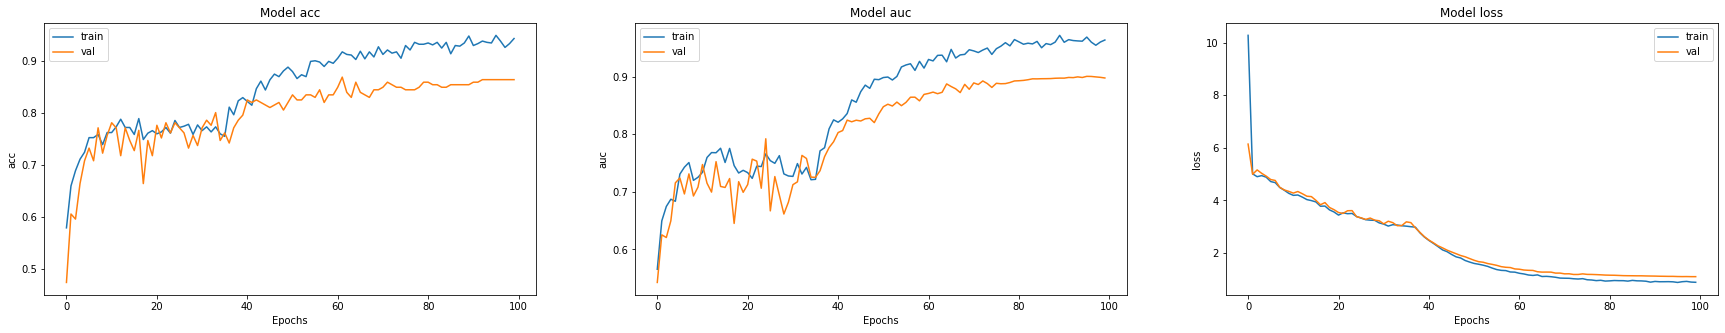

In [25]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [26]:
#Evaluating the model on the data

train_scores = model.evaluate(train_data, train_labels)
val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data, test_labels)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

8/8 [==============================] - 1s 81ms/step - loss: 1.1657 - acc: 0.8359 - auc: 0.8739 - f1_score: 0.8354
Training Accuracy: 99.88%
Validation Accuracy: 86.34%
Testing Accuracy: 83.59%


In [27]:
#Predicting the test data
pred_labels = model.predict(test_data)

8/8 [==============================] - 1s 79ms/step


In [28]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

              precision    recall  f1-score   support

NonAlzheimer       0.83      0.86      0.84       133
   Alzheimer       0.84      0.81      0.83       123

   micro avg       0.84      0.84      0.84       256
   macro avg       0.84      0.84      0.84       256
weighted avg       0.84      0.84      0.84       256
 samples avg       0.84      0.84      0.84       256



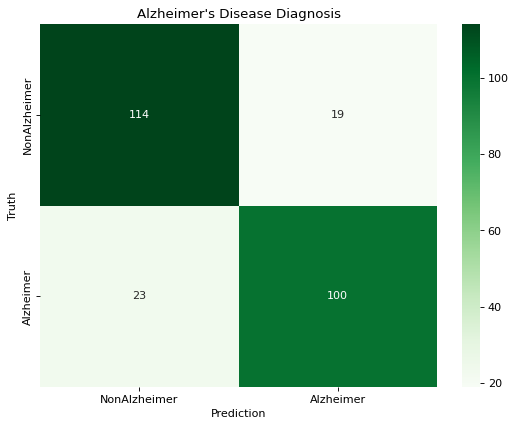

In [29]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)